# Overview 
- Permutation Importance クラスを作成する

# Import everything I need :)

In [169]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import seaborn as sns

# Preparation

## set

In [120]:
pd.set_option('display.max_columns', 100)

<br>

## datasets

In [178]:
boston = load_boston()
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
target = boston.target

df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


<br>

## all function

In [179]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        self.base_score = self.metric(y_valid, self.model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = model.predict(df_perm)
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')
        print('')
        
        
    
# c = permutation_importance(X_valid, y_valid, model, metric)
# c.compute()
# c.get_negative_feature()
# c.show_permutation_importance()

# Permutation Importance

## example1

In [186]:
# create train, validate, data
X = df_boston
y = target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [187]:
# fit
model = RandomForestRegressor(n_estimators=1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

<br>
<br>
do it

,feat,score,score_diff
0,CRIM,3.197368,-0.067105
1,ZN,3.136842,-0.006579
2,INDUS,3.302632,-0.172368
3,CHAS,3.130263,0.000000
4,NOX,3.443421,-0.313158
5,RM,4.670395,-1.540132
6,AGE,3.294737,-0.164474
7,DIS,3.413816,-0.283553
8,RAD,3.215132,-0.084868
9,TAX,3.339474,-0.209211


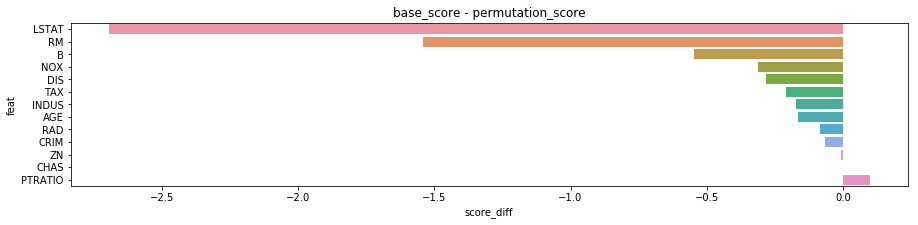

In [188]:
pi = permutation_importance(model, mean_absolute_error)
pi.compute(X_valid, y_valid)
display(pi.df_result)
pi.show_permutation_importance(score_type='loss')  # loss or accuracy

<br>
<br>
- 重要な特徴量のみで学習する

In [189]:
best_feats = pi.get_negative_feature()
# best_feats = pi.get_positive_feature()
best_feats

['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'B', 'LSTAT']

In [190]:
# create train, validate, data
X = df_boston[best_feats]
y = target
X_train_pi, X_valid_pi, y_train_pi, y_valid_pi = train_test_split(X, y, test_size=0.3, random_state=42)

# fit
model_pi = RandomForestRegressor(n_estimators=1, random_state=42)
model_pi.fit(X_train_pi, y_train_pi)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

- 結果の比較

In [191]:
y_valid_pred = model.predict(X_valid)
y_valid_pred_pi = model_pi.predict(X_valid_pi)

print(f'base model error: {mean_absolute_error(y_valid, y_valid_pred) :.4f}')
print(f'best model error: {mean_absolute_error(y_valid_pi, y_valid_pred_pi) :.4f}')

base model error: 3.1303
best model error: 3.0572


---> スコアがさがった